In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import *

From Wikipedia, the Bethe-Bloch formula is given by 
$$- \left\langle\frac{dE}{dx}\right\rangle = \frac{4 \pi}{m_e c^2} \frac{nz^2}{\beta^2}\left(\frac{e^2}{4\pi\varepsilon_0}\right)^2 \left[\ln \left(\frac{2m_e c^2 \beta^2}{I  (1-\beta^2)}\right) - \beta^2\right]$$

where $n = \frac{N_AZ\rho}{A}$ and $I_{Cu}/Z_{Cu} = 11 eV$, $I_{C}/Z_{C} = 15 eV$.

In [2]:
def electronDensity(Z, rho, A):
    return N_A * Z * rho /(A*1.)

def betheBlochFormula(n, z, I, beta = 0.9998):
    toreturn = 4*np.pi/(m_e*c**2) * n*z**2 /(beta**2) * (e**2/(4*np.pi*epsilon_0))**2\
    * (np.log(2*m_e*c**2*beta**2/(I*(1-beta**2)))-beta**2)
    return -1*toreturn

In [3]:
copper_density = 8920. #kg/m3
plastic_density = 940. #kg/m3  Low/High density Polyethilene
copper_I = 11*29*e #Joules
plastic_I = 15*6*e #Joules
copper_elec_dens = electronDensity(29, copper_density, 63.54)
plastic_elec_dens = electronDensity(6, plastic_density, 12)

In [4]:
print 'For Cu', -betheBlochFormula(copper_elec_dens, 1, copper_I)/e *1e-6, 'MeV'
print 'For C (Plastic)', -betheBlochFormula(plastic_elec_dens, 1, plastic_I)/e *1e-6, 'MeV'

For Cu 1.86298756486643 MeV
For C (Plastic) 0.23334606184953993 MeV


# Initial calibration with unknown threshold

In [5]:
import pandas as pd
from scipy import stats
from scipy.optimize import fsolve


In [6]:
raw_data = pd.read_excel('PMT_calib_fixed.xlsx')

def extract_data(r_data, PMT_num):
    PMT_data = r_data[r_data['PMT']==PMT_num]
    PMT_data = PMT_data.drop('PMT', axis=1)
    PMT_data = PMT_data.set_index(PMT_data['Voltage [V]'])
    PMT_data = PMT_data.sort_values('Voltage [V]')
    PMT_matrix = PMT_data.as_matrix()
    return PMT_matrix

In [7]:
matrices = [extract_data(raw_data, i) for i in range(1, 5)]

In [8]:
def line(x, m, b, des):
    return m*x + b - des

def get_calibrating_voltage(PMT_matrix, desired_count):
    V_data = PMT_matrix[:,0]
    count_data = PMT_matrix[:,1]
    log_count_data = np.log(count_data)
    V_mask=[v<=2.3 and v>=2 for v in V_data]
    V_data = V_data[V_mask]
    log_count_data = log_count_data[V_mask]
    plt.plot(V_data, log_count_data)
    slope, intercept, r_value, p_value, std_err = stats.linregress(V_data, log_count_data)
    plt.plot(np.linspace(2, 2.4, 100), slope*np.linspace(2, 2.4, 100)+intercept)
    print slope, intercept
    return fsolve(line, 2, (slope, intercept, desired_count))
    

10.958842155377365 -13.956723702263885
9.726194692053483 -12.396849923273296
11.976162611056242 -17.19367575838576
11.512213778591176 -15.755479007997733


[(1, 2.1404381384172018),
 (2, 2.2513275352346698),
 (3, 2.2289005773637784),
 (4, 2.193798646700288)]

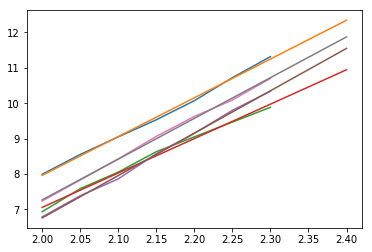

In [9]:
[(i+1,get_calibrating_voltage(matrix, 9.5)[0]) for i, matrix in enumerate(matrices)]

# Calibración Threshold

    Threshold (V)  Counts (10s) source  Counts (10s) no source
31           0.29                84670                   16311
30           1.07                53838                    8590
29           1.22                46825                    6775
28           1.43                39568                    5306
27           1.64                34844                    4272
26           1.83                32054                    3568
25           1.98                30379                    3238
24           2.11                28973                    3148
23           2.25                27921                    2838
22           2.38                26928                    2648
21           2.60                25892                    2624
20           2.70                25353                    2384
19           2.89                24518                    2173
18           3.03                24256                    2073
17           3.19                23269                 

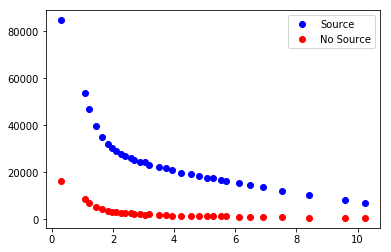

In [10]:
raw_data = pd.read_excel('Threshold_calib.xlsx')
raw_data= raw_data.sort_values('Threshold (V)')
mat = raw_data.as_matrix()
plt.plot(mat[:,0], mat[:,1], 'ob', label='Source')
plt.plot(mat[:,0], mat[:,2], 'or', label='No Source')
plt.legend(loc=0)
print raw_data

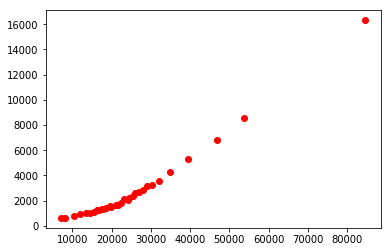

In [11]:
plt.plot(mat[:,1], mat[:,2], 'or', label='Source vs. No Source')

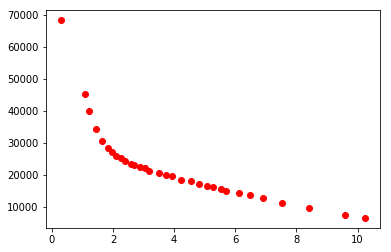

In [12]:
plt.plot(mat[:,0], mat[:,1]-mat[:,2], 'or', label='Source - No Source')


+ Compton scattering: Relation between incoming photon and electron energy
+ Muon decay products' energy
+ More precise threshold measurements


In [13]:
def electron_E(E_gamma):
    return E_gamma*(1-1./(1+2*(E_gamma/(511e-3))))

In [14]:
gamma_energies = [1.17, 1.33]
print [electron_E(E) for E in gamma_energies], 'MeV'

[0.9602946334619431, 1.115673289183223] MeV


# Cumulative Spectrum

[[  40.05185545   79.46223396]
 [  43.23448388  149.3218865 ]
 [  46.4171123   244.2255654 ]
 [  49.59974072  329.9024977 ]
 [  68.69551126  422.9608273 ]
 [  89.38259601  500.3776246 ]
 [ 111.660995    561.170301  ]
 [ 146.6699076   501.4960181 ]
 [ 181.6788203   532.4116105 ]
 [ 216.6877329   558.7737435 ]
 [ 246.922703    597.4781479 ]
 [ 262.8358451   660.7472671 ]
 [ 270.7924161   727.9707064 ]
 [ 293.3890779   798.6212229 ]
 [ 289.8881867   838.6916651 ]
 [ 323.3057851   699.6314134 ]
 [ 345.5841841   646.248094  ]
 [ 372.6365257   583.4582862 ]
 [ 407.6454383   560.211678  ]
 [ 442.654351    532.4116105 ]
 [ 477.6632637   512.0408713 ]
 [ 512.6721763   498.620149  ]
 [ 547.681089    516.1150191 ]
 [ 582.6900016   525.7012493 ]
 [ 617.6989143   501.0167066 ]
 [ 652.7078269   522.8253803 ]
 [ 687.7167396   508.6856907 ]
 [ 722.7256522   515.6357076 ]
 [ 757.7345649   531.4529874 ]
 [ 792.7434776   538.4030043 ]
 [ 827.7523902   559.253055  ]
 [ 862.7613029   578.9048269 ]
 [ 897.7

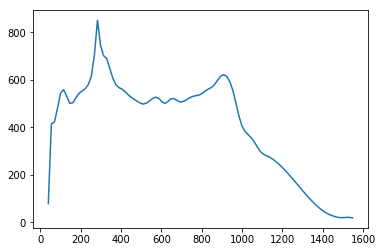

In [35]:
from scipy import interpolate
spectrum = np.loadtxt('Co_Spectrum.csv', delimiter =',')
print spectrum
def cumulate_spectrum(spectrum):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1], kind='cubic')
    x = np.linspace(spectrum[:,0][0], spectrum[:,0][-1], 100)
decumulate_spectrum(spectrum)

In [17]:
#This function can either print or store the markov chain. For parallel computing it is easier to print.
def MH_Spectrum_Sampling(spectrum, niter):
    evaluate_spectrum = interpolate.interp1d(spectrum[:,0], spectrum[:,1])
    markov_chain=[]
    max_interval=spectrum[:,0][-1]
    initial_value=max_interval*np.random.random()
    #print initial_value
    markov_chain.append(initial_value)
    for i in range(niter):
        std = 10**(np.log10(spectrum[:,0][-1]))
        to_try = np.random.normal(markov_chain[i], std)
        while(to_try<spectrum[:,0][0] or to_try>spectrum[:,0][-1]):
            to_try = np.random.normal(markov_chain[i], std)
        possible_jump=to_try
        criteria = evaluate_spectrum(possible_jump)/evaluate_spectrum(markov_chain[i])
        if(criteria>=1.):
            #print abs(possible_jump)
            markov_chain.append(abs(possible_jump))
        else:
            other_random = np.random.random()
            if(other_random<=criteria):
                #print possible_jump
                markov_chain.append(possible_jump)
            else:
                #print markov_chain[i]
                markov_chain.append(markov_chain[i])
    return np.array(markov_chain)

In [60]:
raw_data_Co = pd.read_excel('Threshold_calib.xlsx')

def decumulate_measured_spectrum(raw_data, kind):
    raw_data= raw_data.sort_values('Threshold (V)')
    mat = raw_data.as_matrix()
    measured_spectrum = np.column_stack((mat[:,0], mat[:,1]-mat[:,2]))
    evaluate_measured_spectrum = interpolate.interp1d(measured_spectrum[:,0], measured_spectrum[:,1], kind = kind)
    freqs = evaluate_measured_spectrum(np.linspace(0.29, 10.24, 100))
    uncumulated = [freqs[i]-freqs[i+1] for i in range(len(freqs)-1)]
    return np.linspace(0.29, 10.24, 100)[:-1], uncumulated

In [61]:
x, y = decumulate_measured_spectrum(raw_data_Co, 'linear')

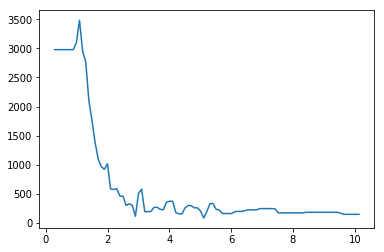

In [62]:
plt.plot(x, y)

plt.plot(x, y)